## Setup kaggle API

## Import Important Packages

In [1]:

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Input
from sklearn.utils import shuffle
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pandas as pd
DATASET_ENCODING = "ISO-8859-1"


In [2]:
tf.__version__

'2.6.2'

## Download and process Twitter Sentiment dataset

In [3]:
#!kaggle datasets download -d kazanova/sentiment140

In [4]:
df = pd.read_csv("content/sentiment140.zip",encoding=DATASET_ENCODING)
df= df.iloc[:,[0,-1]]
df.columns = ['sentiment','tweet']
df = pd.concat([df.query("sentiment==0").sample(20000),df.query("sentiment==4").sample(20000)])
df.sentiment = df.sentiment.map({0:0,4:1})
df =  shuffle(df).reset_index(drop=True)

df,df_test = train_test_split(df,test_size=0.2)

In [5]:
df.head(5)

,sentiment,tweet
1798,0,I can't believe I spent a whole working day tr...
24235,0,"@mi_alegria my mom's kids are the same way, bu..."
6941,1,@brittanyboren that was so random to see you t...
35693,1,cant wait to go back to school tomorrow really...
2623,0,...i wish i lived in Texas


In [16]:
len(df)

32000

In [19]:
df.sentiment.max()

1

## Load Universal Sentence Encoder from TFhub

In [6]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


In [10]:
embed(['cccc this is our project']).numpy().shape

(1, 512)

In [29]:
embed(['cccc this is our project. noooo']).numpy()

array([[ 9.03854147e-03,  5.22774868e-02,  6.13305857e-03,
         2.37341207e-02,  6.30642995e-02, -3.62927765e-02,
         3.57606933e-02, -4.58553694e-02,  9.47707668e-02,
        -2.52315421e-02, -4.95872367e-03, -6.29206374e-02,
         9.89571810e-02,  5.19171953e-02,  4.39674109e-02,
        -7.71288341e-03, -1.15632545e-04, -4.09453884e-02,
        -3.64664546e-03, -8.83569047e-02,  4.98004584e-03,
         3.77035365e-02,  3.35923322e-02, -2.12137345e-02,
        -2.27638390e-02, -5.42797409e-02,  7.34127220e-03,
        -5.47480509e-02,  2.67833192e-02,  5.73655032e-02,
         2.97581591e-02, -3.30158568e-04, -1.60164628e-02,
         6.42586779e-03,  2.42630076e-02, -9.27571878e-02,
        -6.32871762e-02,  1.67394951e-02, -1.74661241e-02,
         3.71933170e-02,  2.84864381e-02, -1.25712007e-02,
         1.55060450e-02, -2.67616510e-02, -4.62858602e-02,
        -6.77554170e-03, -2.98638027e-02, -1.96758527e-02,
         2.28325054e-02, -6.67092577e-02,  2.12443564e-0

In [11]:
def vectorize(df):
    embeded_tweets = embed(df['tweet'].values.tolist()).numpy()
    targets = df.sentiment.values
    return embeded_tweets,targets

embeded_tweets,targets = vectorize(df)


## Model 

In [13]:
model = Sequential()
model.add(Input(shape=(512,),dtype='float32'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['acc'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 73,985
Trainable params: 73,985
Non-trainable params: 0
_________________________________________________________________


## Train and evaluate

In [15]:
num_epochs = 10
batch_size = 32   ## 2^x

history = model.fit(embeded_tweets, 
                    targets, 
                    epochs=num_epochs, 
                    validation_split=0.1, 
                    shuffle=True,
                    batch_size=batch_size)

Epoch 1/10
900/900 [==============================] - 5s 5ms/step - loss: 0.4789 - acc: 0.7754 - val_loss: 0.4577 - val_acc: 0.7847
Epoch 2/10
900/900 [==============================] - 4s 5ms/step - loss: 0.4440 - acc: 0.7916 - val_loss: 0.4564 - val_acc: 0.7834
Epoch 3/10
900/900 [==============================] - 4s 5ms/step - loss: 0.4190 - acc: 0.8084 - val_loss: 0.4604 - val_acc: 0.7825
Epoch 4/10
900/900 [==============================] - 4s 5ms/step - loss: 0.3853 - acc: 0.8283 - val_loss: 0.4750 - val_acc: 0.7784
Epoch 5/10
900/900 [==============================] - 4s 5ms/step - loss: 0.3468 - acc: 0.8504 - val_loss: 0.4999 - val_acc: 0.7803
Epoch 6/10
900/900 [==============================] - 4s 5ms/step - loss: 0.3048 - acc: 0.8732 - val_loss: 0.5284 - val_acc: 0.7741
Epoch 7/10
900/900 [==============================] - 4s 5ms/step - loss: 0.2628 - acc: 0.8926 - val_loss: 0.6041 - val_acc: 0.7584
Epoch 8/10
900/900 [==============================] - 4s 5ms/step - loss: 0.

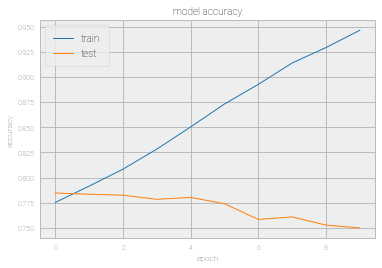

In [20]:


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


## Compare results


In [21]:
from sklearn.metrics import accuracy_score

## Custom Model 

In [22]:
embed_test,targets = vectorize(df_test)
predictions = model.predict(embed_test).astype(int)
accuracy_score(predictions,targets)*100

49.737500000000004

## Textblob

In [ ]:
!pip install -q textblob 

In [23]:
from textblob import TextBlob

def text_sentiment(text):
    testimonial = TextBlob(text)
    return int(testimonial.sentiment.polarity>0.5)

predictions = df_test.tweet.map(lambda x :  text_sentiment(x))
accuracy_score(predictions,targets)

0.55375

In [24]:
analyzer.polarity_scores("The food as great!")

NameError: name 'analyzer' is not defined

## Vader

In [ ]:
pip install -q vaderSentiment

     |████████████████████████████████| 133kB 9.5MB/s 


In [25]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def text_sentiment_vader(text):
 vs = analyzer.polarity_scores(text)
 return int(vs.get("compound")>0)
 
 predictions = df_test.tweet.map(lambda x : text_sentiment_vader(x))


In [26]:
 accuracy_score(predictions.values,targets)

0.55375

## Flair

In [ ]:
!pip install -q flair 

     |████████████████████████████████| 337kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 13.0MB/s 
     |████████████████████████████████| 19.7MB 1.2MB/s 
     |████████████████████████████████| 276kB 48.2MB/s 
     |████████████████████████████████| 1.1MB 47.7MB/s 
     |████████████████████████████████| 798kB 41.8MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
     |████████████████████████████████| 983kB 43.8MB/s 
     |████████████████████████████████| 3.0MB 46.2MB/s 
     |████████████████████████████████| 890kB 39.0MB/s 
  Created wheel for segtok: filename=segtok-1.5.10-cp36-none-any.whl size=25021 sha256=cf47a3857790931cc2e5d624ea7bf233b3524bcabb924d133dbf76a2403dc921
  Stored in directory: /root/.cache/pip/wheels/b4/39/f6/9ca1c5cabde964d728023b5751c3a206a5c8cc40252321fb6b
  Created wheel for sqlitedict: filename=sqlitedict-1.7.0-cp36-none-any.whl size=14377 sha256=145c5230dc506b01f398b0d14568379c037aa1e5d9e8cd27300d09d554c1afa5
  Stored in directory: /r

In [27]:
from flair.models import TextClassifier
from flair.data import Sentence
classifier = TextClassifier.load('en-sentiment')

def text_sentiment_flair(text):
  sentence = Sentence(text)
  classifier.predict(sentence)
  return np.round(sentence.labels[0].score)

predictions = df_test.tweet.map(lambda x : text_sentiment_flair(x))


2022-01-19 14:58:16,393 loading file /home/cdsw/.flair/models/sentiment-en-mix-distillbert_4.pt


In [28]:
accuracy_score(predictions.values,targets)


0.50375

In [ ]:
sentence=Sentence("The food was great!")
classifier.predict(sentence)
sentence.labels

[POSITIVE (0.9961)]